In [1]:
!pip install snapml

     ---------------------------------------- 1.2/1.2 MB 18.5 MB/s eta 0:00:00


In [2]:
import warnings
warnings.filterwarnings('ignore')

# from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import roc_auc_score
import time
import gc, sys

In [6]:
# read the input data
raw_data = pd.read_csv('creditcard.csv')
print("There are " + str(len(raw_data)) + " observations in the credit card fraud dataset.")
print("There are " + str(len(raw_data.columns)) + " variables in the dataset.")

# display the first rows in the dataset
raw_data.head()

There are 284807 observations in the credit card fraud dataset.
There are 31 variables in the dataset.


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [7]:
n_replicas = 10

# inflate the original dataset
big_raw_data = pd.DataFrame(np.repeat(raw_data.values, n_replicas, axis=0), columns=raw_data.columns)

print("There are " + str(len(big_raw_data)) + " observations in the inflated credit card fraud dataset.")
print("There are " + str(len(big_raw_data.columns)) + " variables in the dataset.")

# display first rows in the new dataset
big_raw_data.head()

There are 2848070 observations in the inflated credit card fraud dataset.
There are 31 variables in the dataset.


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
2,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
3,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
4,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0


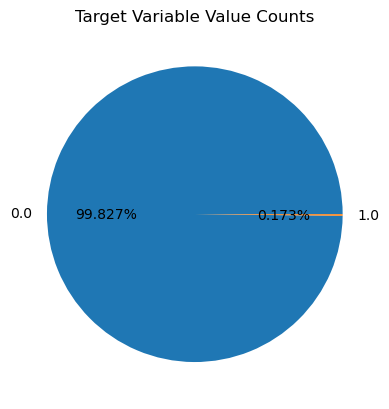

In [8]:
# get the set of distinct classes
labels = big_raw_data.Class.unique()

# get the count of each class
sizes = big_raw_data.Class.value_counts().values

# plot the class value counts
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.3f%%')
ax.set_title('Target Variable Value Counts')
plt.show()

In [9]:
big_raw_data.iloc[:, 1:30] = StandardScaler().fit_transform(big_raw_data.iloc[:, 1:30])
data_matrix = big_raw_data.values

# X: feature matrix (for this analysis, we exclude the Time variable from the dataset)
X = data_matrix[:, 1:30]

# y: labels vector
y = data_matrix[:, 30]

# data normalization
X = normalize(X, norm="l1")

# print the shape of the features matrix and the labels vector
print('X.shape=', X.shape, 'y.shape=', y.shape)

X.shape= (2848070, 29) y.shape= (2848070,)


In [10]:
del raw_data
del big_raw_data
gc.collect()

0

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)       
print('X_train.shape=', X_train.shape, 'Y_train.shape=', y_train.shape)
print('X_test.shape=', X_test.shape, 'Y_test.shape=', y_test.shape)

X_train.shape= (1993649, 29) Y_train.shape= (1993649,)
X_test.shape= (854421, 29) Y_test.shape= (854421,)


In [12]:
w_train = compute_sample_weight('balanced', y_train)

In [13]:
from sklearn.tree import DecisionTreeClassifier

In [14]:
sklearn_dt = DecisionTreeClassifier(max_depth=4, random_state=35)

In [15]:
t0 = time.time()
sklearn_dt.fit(X_train, y_train, sample_weight=w_train)
sklearn_time = time.time()-t0
print("[Scikit-Learn] Training time (s):  {0:.5f}".format(sklearn_time))

[Scikit-Learn] Training time (s):  22.87743


In [16]:
from snapml import DecisionTreeClassifier

In [17]:
snapml_dt = DecisionTreeClassifier(max_depth=4, random_state=45, n_jobs=4)

In [18]:
# train a Decision Tree Classifier model using Snap ML
t0 = time.time()
snapml_dt.fit(X_train, y_train, sample_weight=w_train)
snapml_time = time.time()-t0
print("[Snap ML] Training time (s):  {0:.5f}".format(snapml_time))

[Snap ML] Training time (s):  2.66385


In [19]:
# Snap ML vs Scikit-Learn training speedup
training_speedup = sklearn_time/snapml_time
print('[Decision Tree Classifier] Snap ML vs. Scikit-Learn speedup : {0:.2f}x '.format(training_speedup))

[Decision Tree Classifier] Snap ML vs. Scikit-Learn speedup : 8.59x 


In [20]:
sklearn_pred = sklearn_dt.predict_proba(X_test)[:,1]
snapml_pred = snapml_dt.predict_proba(X_test)[:,1]

In [21]:
sklearn_roc_auc = roc_auc_score(y_test, sklearn_pred)
print('[Scikit-Learn] ROC-AUC score : {0:.3f}'.format(sklearn_roc_auc))

snapml_roc_auc = roc_auc_score(y_test, snapml_pred)   
print('[Snap ML] ROC-AUC score : {0:.3f}'.format(snapml_roc_auc))

[Scikit-Learn] ROC-AUC score : 0.966
[Snap ML] ROC-AUC score : 0.966


In [26]:
from sklearn.svm import LinearSVC

In [27]:
sklearn_svm = LinearSVC(class_weight='balanced', random_state=31, loss="hinge", fit_intercept=False)

In [28]:
t0 = time.time()
sklearn_svm.fit (X_train, y_train)
sklearn_time = time.time() - t0
print("[Scikit-Learn] Training time (s):  {0:.2f}".format(sklearn_time))

[Scikit-Learn] Training time (s):  54.20


In [29]:
from snapml import SupportVectorMachine

In [30]:
snapml_svm = SupportVectorMachine(class_weight='balanced', random_state=25, n_jobs=4, fit_intercept=False)
print(snapml_svm.get_params())

{'class_weight': 'balanced', 'device_ids': [], 'fit_intercept': False, 'gamma': 1.0, 'generate_training_history': None, 'intercept_scaling': 1.0, 'kernel': 'linear', 'loss': 'hinge', 'max_iter': 1000, 'n_components': 100, 'n_jobs': 4, 'normalize': False, 'random_state': 25, 'regularizer': 1.0, 'tol': 0.001, 'use_gpu': False, 'verbose': False}


In [31]:
t0 = time.time()
model = snapml_svm.fit(X_train, y_train)
snapml_time = time.time() - t0
print("[Snap ML] Training time (s):  {0:.2f}".format(snapml_time))

[Snap ML] Training time (s):  6.56


In [32]:
# compute the Snap ML vs Scikit-Learn training speedup
training_speedup = sklearn_time/snapml_time
print('[Support Vector Machine] Snap ML vs. Scikit-Learn training speedup : {0:.2f}x '.format(training_speedup))

[Support Vector Machine] Snap ML vs. Scikit-Learn training speedup : 8.27x 


In [33]:
sklearn_pred = sklearn_svm.decision_function(X_test)
snapml_pred = snapml_svm.decision_function(X_test)

In [34]:
acc_sklearn  = roc_auc_score(y_test, sklearn_pred)
print("[Scikit-Learn] ROC-AUC score:   {0:.3f}".format(acc_sklearn))

acc_snapml  = roc_auc_score(y_test, snapml_pred)
print("[Snap ML] ROC-AUC score:   {0:.3f}".format(acc_snapml))

[Scikit-Learn] ROC-AUC score:   0.984
[Snap ML] ROC-AUC score:   0.985
